# Quick Chart

This is a workbook for making a single chart. The initial load is all condensed into one cell so the environment can be quickly setup

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.transforms as mtransforms
import matplotlib
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.feature_extraction.text import CountVectorizer, Tficommander_commander_commander_commander_dfVectorizer
from scipy.stats import zscore
import requests
from datetime import datetime, timedelta
import os
import glob
import json
import pprint

sns.set_theme()
sns.set_context("poster")

# Constants for the API call
API_URL = "https://api.scryfall.com/bulk-data"

# Function to download the default cards file
def download_file(download_uri, filename):
    response = requests.get(download_uri)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded the new file: {filename}")
        return filename
    else:
        print("Failed to download file.")
        return None

# Step 1: Check the directory for the 'default-cards' file
file_pattern = "default-cards*.json"  # Adjust pattern as needed
file_list = glob.glob(file_pattern)
latest_file = None

# Determine the latest file based on the modification time
for file in file_list:
    if latest_file is None or os.path.getmtime(file) > os.path.getmtime(latest_file):
        latest_file = file

data_file = latest_file  # Assume the latest local file is the data file

# If there's no latest file found or it's older than a week, download a new one
if latest_file is None or (datetime.now() - datetime.fromtimestamp(os.path.getmtime(latest_file))) > timedelta(days=7):
    response = requests.get(API_URL)
    if response.status_code == 200:
        bulk_data_info = response.json()
        for entry in bulk_data_info.get("data", []):
            if entry["name"].lower() == "default cards":
                # Found the default cards entry, proceed to download
                filename = entry["download_uri"].split('/')[-1]
                data_file = download_file(entry["download_uri"], filename)
                break
    else:
        print("Failed to retrieve data from the API")
else:
    print(f"The latest data file available is '{data_file}' and it is not a week old yet.")

# Ensure `data_file` is not None and is the latest file
if data_file is None:
    print("No valid data file found or downloaded.")
else:
    print(f"Using the data file: {data_file}")

# At this point, `data_file` will have the name of the latest file

# Load data from the file
df= pd.read_json(data_file)

# Keywords to exclude
excluded_keywords = ["token", "playtest", "scheme", "planechase", "sticker", "art series", "alchemy", "anthology"]

# Filter out sets based on keywords
df = df[~df['set_name'].str.lower().str.contains('|'.join(excluded_keywords))]

# Handle NaN values in 'oracle_text'
df['oracle_text'] = df['oracle_text'].fillna('')

# Remove sets with fewer than 30 cards
#filtered_sets = df['set_name'].value_counts()
#valid_sets = filtered_sets[filtered_sets >= 30].index
#df = df[df['set_name'].isin(valid_sets)]

# Filtering out rows where set_name starts with "un" (case-insensitive)
df = df[~df['set_name'].str.lower().str.startswith('un')]

# Assuming 'released_at' is a string representing dates, convert to datetime
df['released_at'] = pd.to_datetime(df['released_at'], errors='coerce')

# Drop rows with NaT in 'released_at' if any conversion errors occurred
df = df.dropna(subset=['released_at'])

# Extract year from 'released_at' datetime column
df['release_year'] = df['released_at'].dt.year

# Filter out all data from 2024
df = df[df['release_year'] != 2024]

The latest data file available is 'default-cards-20231106100506.json' and it is not a week old yet.
Using the data file: default-cards-20231106100506.json


In [16]:
display(df.columns)

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id',
       'mtgo_foil_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang',
       'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image',
       'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'power', 'toughness', 'colors', 'color_identity',
       'keywords', 'legalities', 'games', 'reserved', 'foil', 'nonfoil',
       'finishes', 'oversized', 'promo', 'reprint', 'variation', 'set_id',
       'set', 'set_name', 'set_type', 'set_uri', 'set_search_uri',
       'scryfall_set_uri', 'rulings_uri', 'prints_search_uri',
       'collector_number', 'digital', 'rarity', 'flavor_text', 'card_back_id',
       'artist', 'artist_ids', 'illustration_id', 'border_color', 'frame',
       'full_art', 'textless', 'booster', 'story_spotlight', 'edhrec_rank',
       'penny_rank', 'prices', 'related_uris', 'purchase_uris', 'all_parts',
       'promo_types', 'arena_id', 'security_stamp', 'card_faces'

# Commander Players

Let's look at Commander Data

First filter to only commander sets to see how that has changed.
Fully look at commanders
Blend EDHREC Data?

**Ideas** <br>
How many new commanders per year? <br>
How many commanders printed per year?

Filters

1. Set name contains the word "Commander"
2. Set name does not contain "minigame"
3. Type line does not contain "token"

Dataframes

1. commander_df - Filtered dataframe
2. unique_commander_df - Filtered dataframe with unique cards. Only the earliest printing is kept. This should show reprints

In [57]:
commander_df = df[df['set_name'].str.contains('commander', case=False, na=False)]
commander_df = commander_df[~commander_df['set_name'].str.contains("minigame", case=False, na=False)]
# Filter rows where 'type_line' contains "token"
commander_df = commander_df[~commander_df['type_line'].str.contains('token', case=False, na=False)]

unique_sets = commander_df['set_name'].unique()

print(f"Unique sets: {len(unique_sets)}")
print(f"Total cards: {len(commander_df)}")
print(f"Total unique cards: {len(commander_df['name'].unique())}")
print(f"Total unique cards with oracle text: {len(commander_df[commander_df['oracle_text'] != '']['name'].unique())}")
print()

# for set_name in unique_sets:
#     print(set_name)

# Sort the DataFrame by 'released_at' in ascending order
unique_commander_df = commander_df.sort_values(by='released_at')

# Drop duplicates based on the 'name' column and keep only the earliest version of each unique name
unique_commander_df = commander_df.drop_duplicates(subset='name', keep='first')

print(f"Total unique cards check: {len(unique_commander_df) == len(commander_df['name'].unique())}")
# Compare the number of unique cards and print the result as a boolean

Unique sets: 48
Total cards: 11013
Total unique cards: 5036
Total unique cards with oracle text: 4973

Total unique cards check: True


In [45]:
print(df.columns)

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id',
       'mtgo_foil_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang',
       'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image',
       'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'power', 'toughness', 'colors', 'color_identity',
       'keywords', 'legalities', 'games', 'reserved', 'foil', 'nonfoil',
       'finishes', 'oversized', 'promo', 'reprint', 'variation', 'set_id',
       'set', 'set_name', 'set_type', 'set_uri', 'set_search_uri',
       'scryfall_set_uri', 'rulings_uri', 'prints_search_uri',
       'collector_number', 'digital', 'rarity', 'flavor_text', 'card_back_id',
       'artist', 'artist_ids', 'illustration_id', 'border_color', 'frame',
       'full_art', 'textless', 'booster', 'story_spotlight', 'edhrec_rank',
       'penny_rank', 'prices', 'related_uris', 'purchase_uris', 'all_parts',
       'promo_types', 'arena_id', 'security_stamp', 'card_faces'

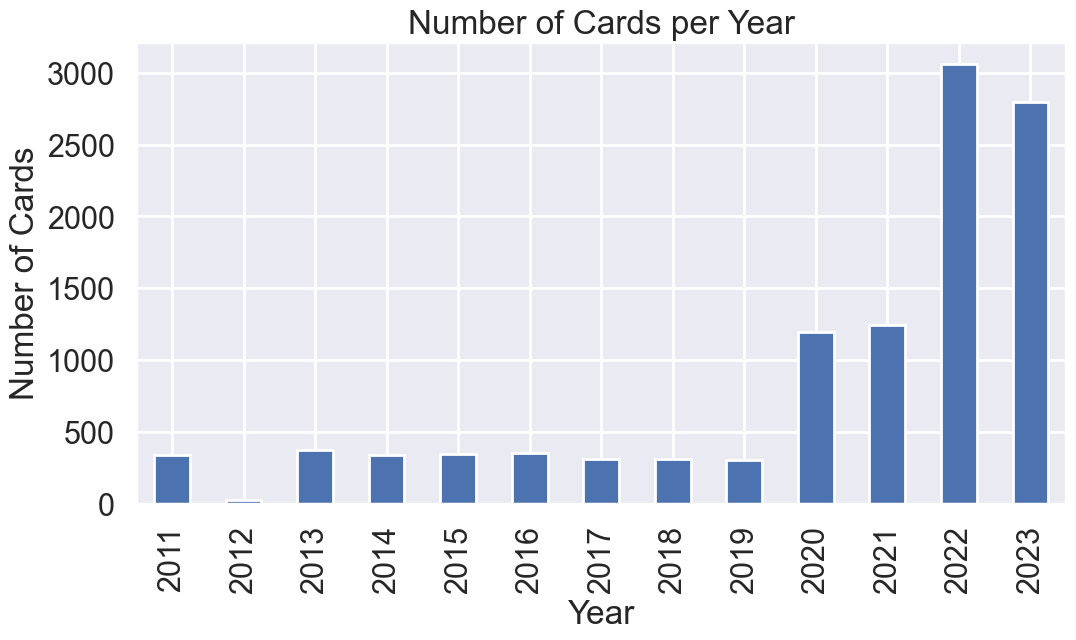

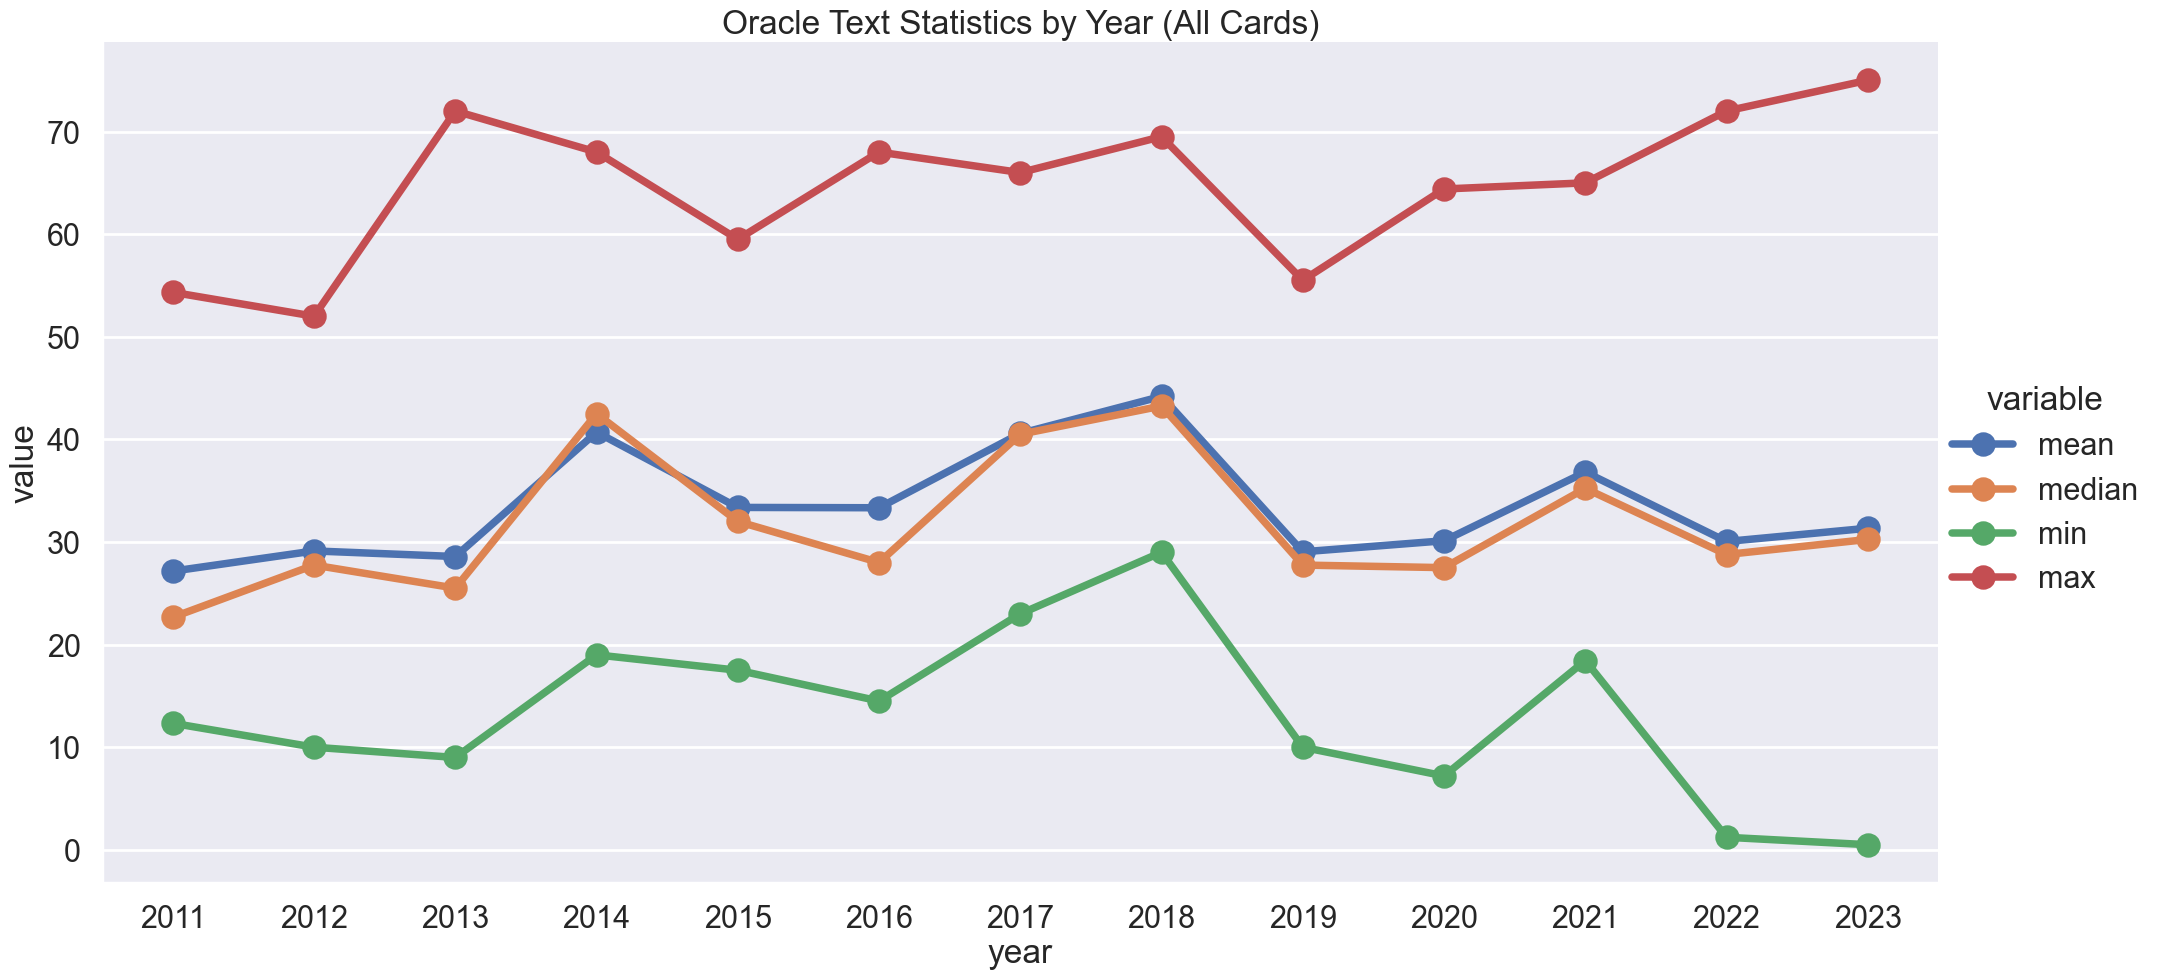

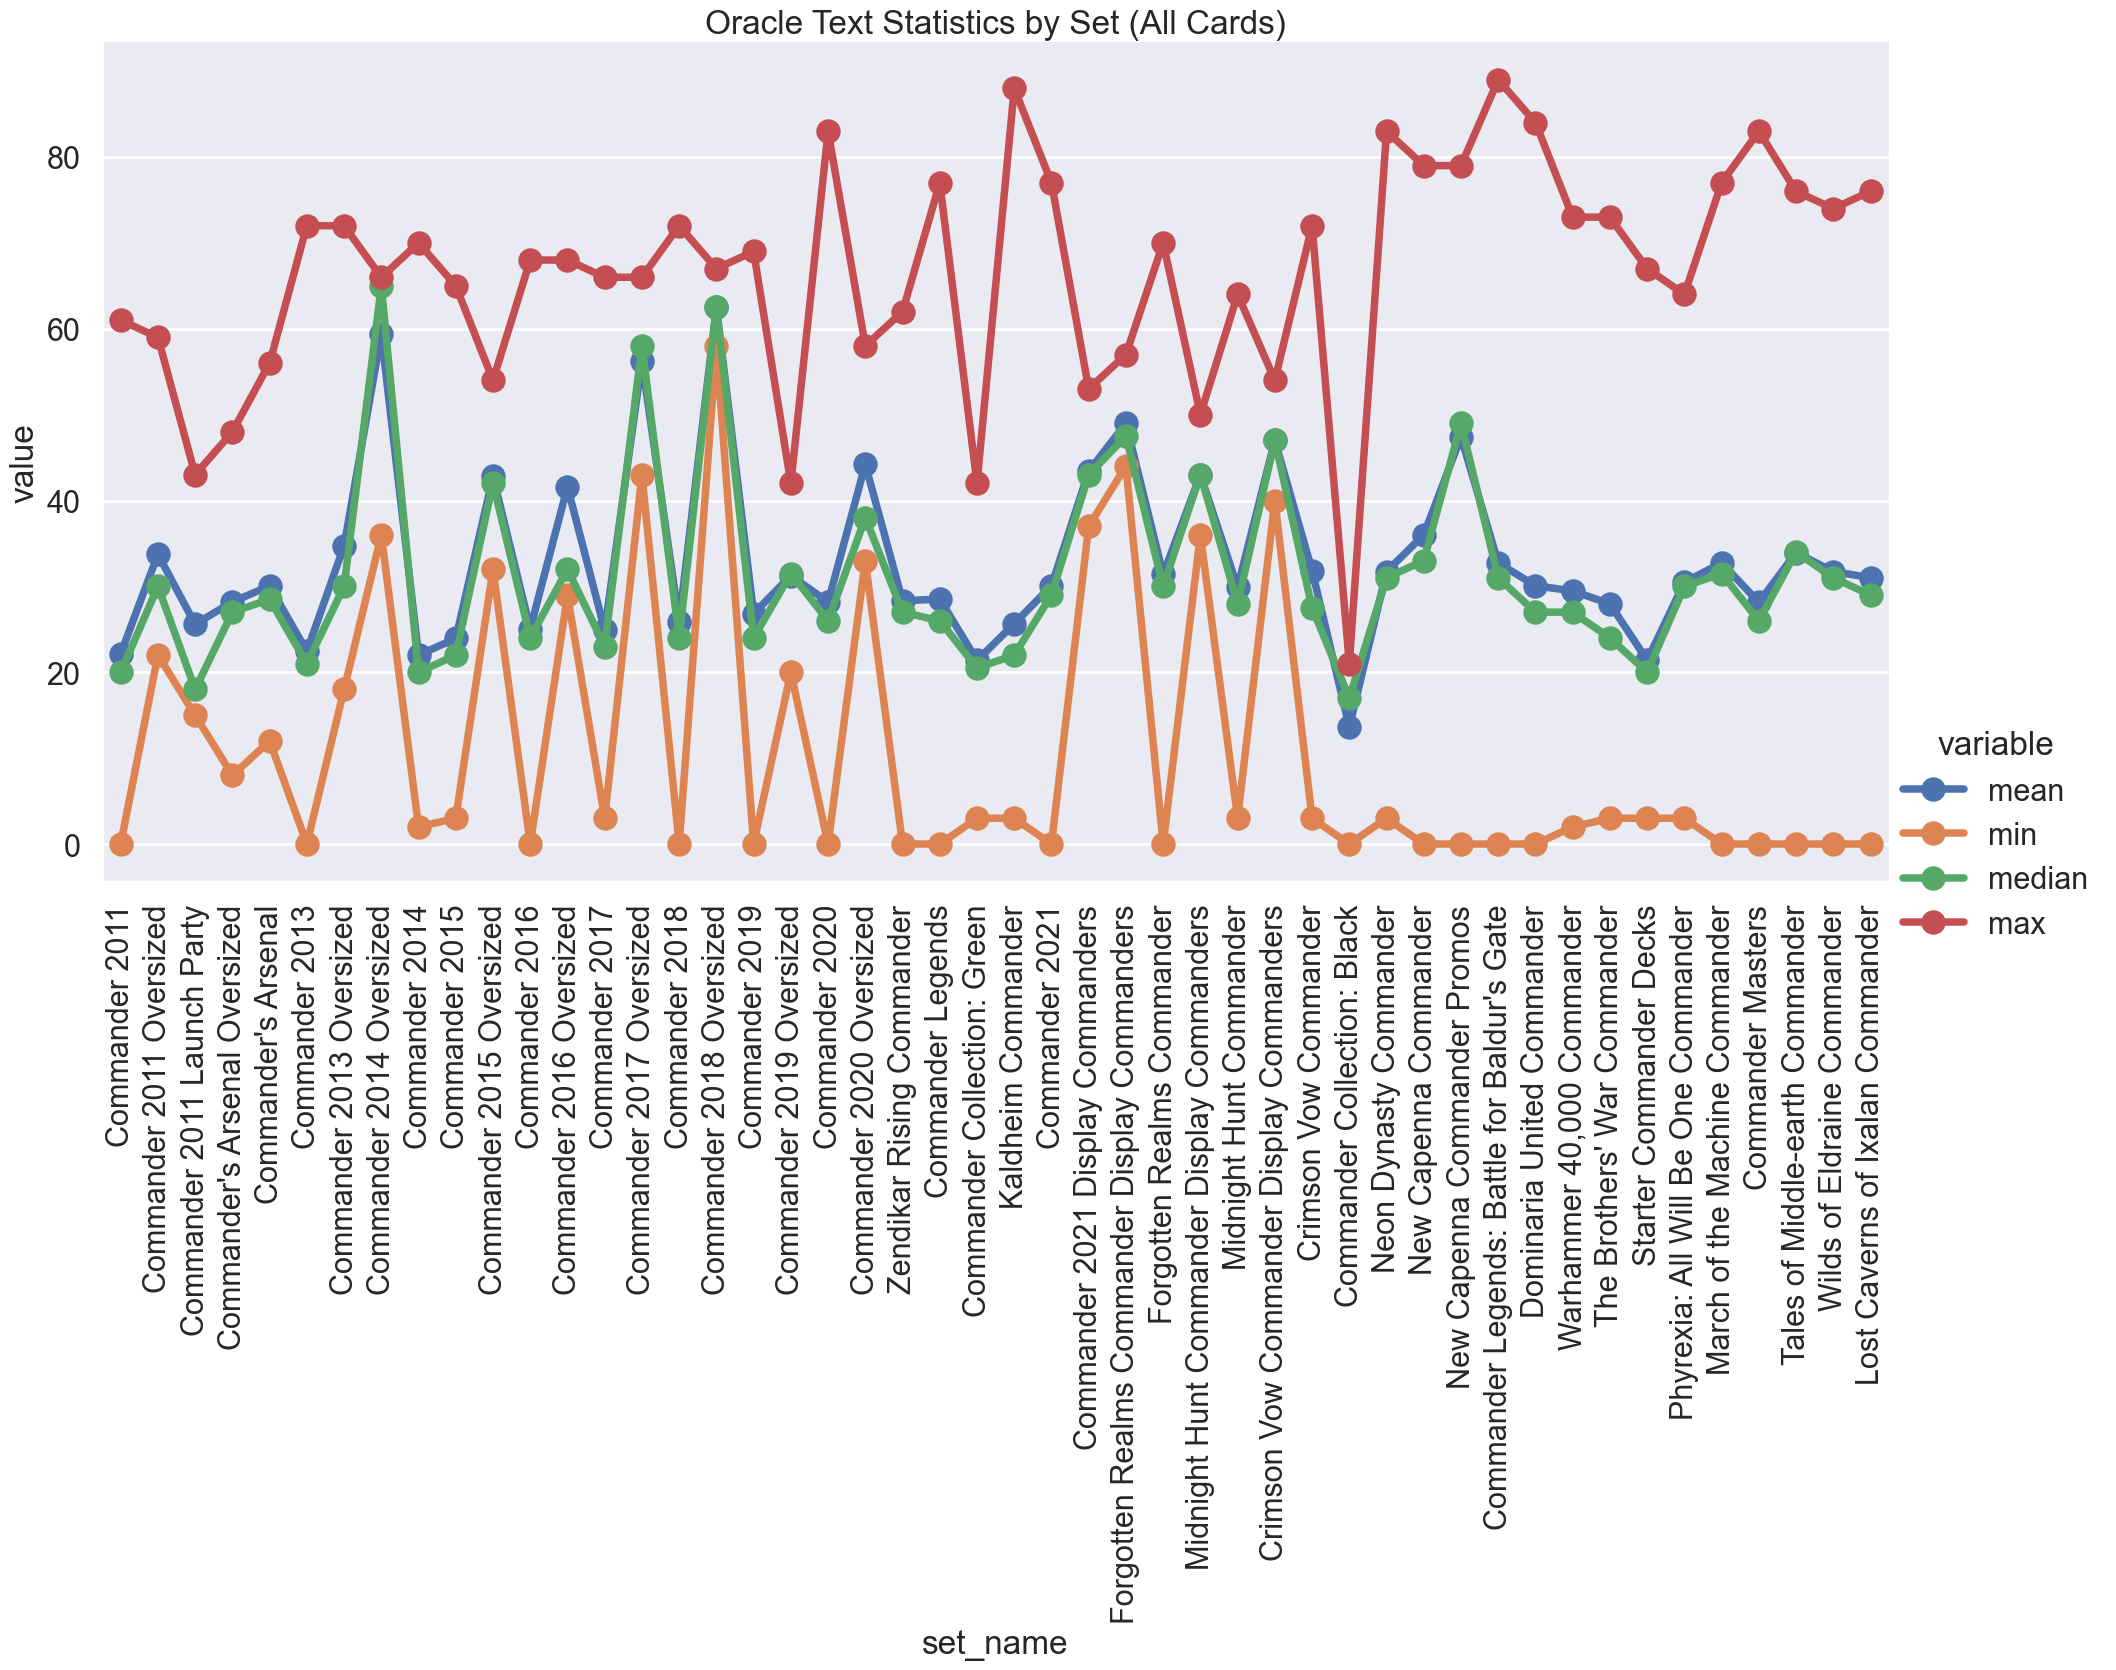

In [60]:
commander_df.loc[:, 'released_at'] = pd.to_datetime(commander_df['released_at'])
commander_df.loc[:, 'year'] = commander_df['released_at'].dt.year

# Group the data by 'year' and get the number of cards in each group
cards_per_year = commander_df.groupby('year').size()

# Create a graph showing the number of cards per year
cards_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Commander Cards per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cards')
plt.show()

# Count the number of words in each oracle_text
commander_df.loc[:, 'word_count'] = commander_df['oracle_text'].apply(lambda x: len(str(x).split()))

# Group by set and year, and calculate mean, median, min, and max word count
stats = commander_df.groupby(['set_name', 'year'])['word_count'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Reshape the DataFrame for easier plotting
melted_stats = stats.melt(id_vars=['set_name', 'year'], value_vars=['mean', 'median', 'min', 'max'])

# Create a bar plot with 'year' on the x-axis
sns.catplot(data=melted_stats, x='year', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.title('Oracle Text Statistics by Year (All Cards)')
plt.show()

# Merge 'released_at' back into the 'melted_stats' DataFrame
melted_stats = pd.merge(melted_stats, commander_df[['set_name', 'year', 'released_at']].drop_duplicates(), on=['set_name', 'year'], how='left')

# Sort the DataFrame by 'released_at'
melted_stats_sorted = melted_stats.sort_values(by='released_at')

# Create a bar plot with 'set_name' on the x-axis
sns.catplot(data=melted_stats_sorted, x='set_name', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Oracle Text Statistics by Set (All Cards)')
plt.show()

----

 Now lets do it again with reprints removed

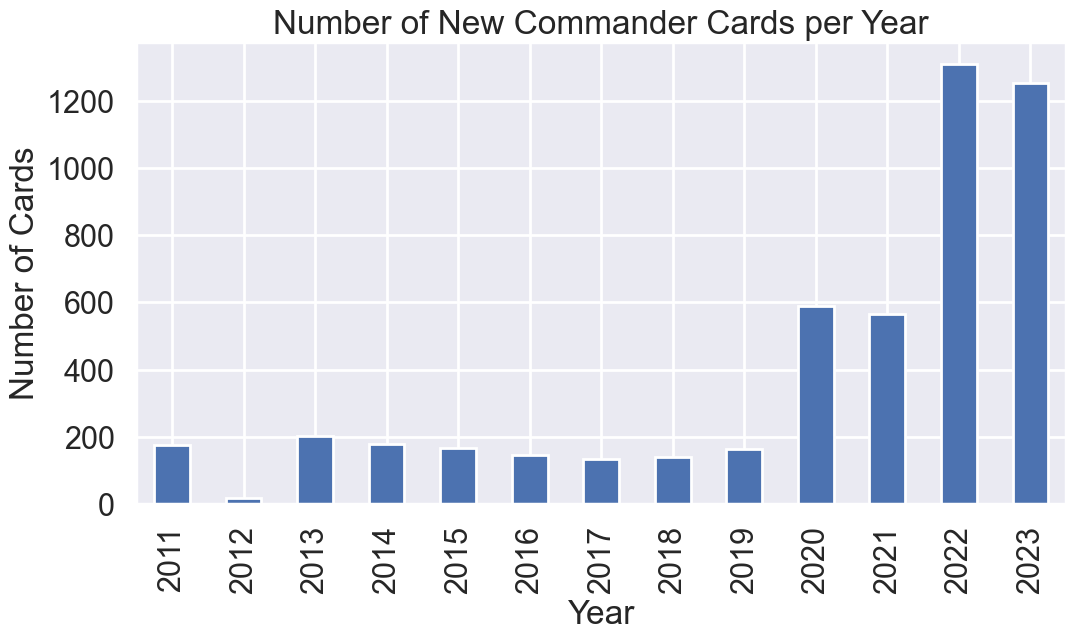

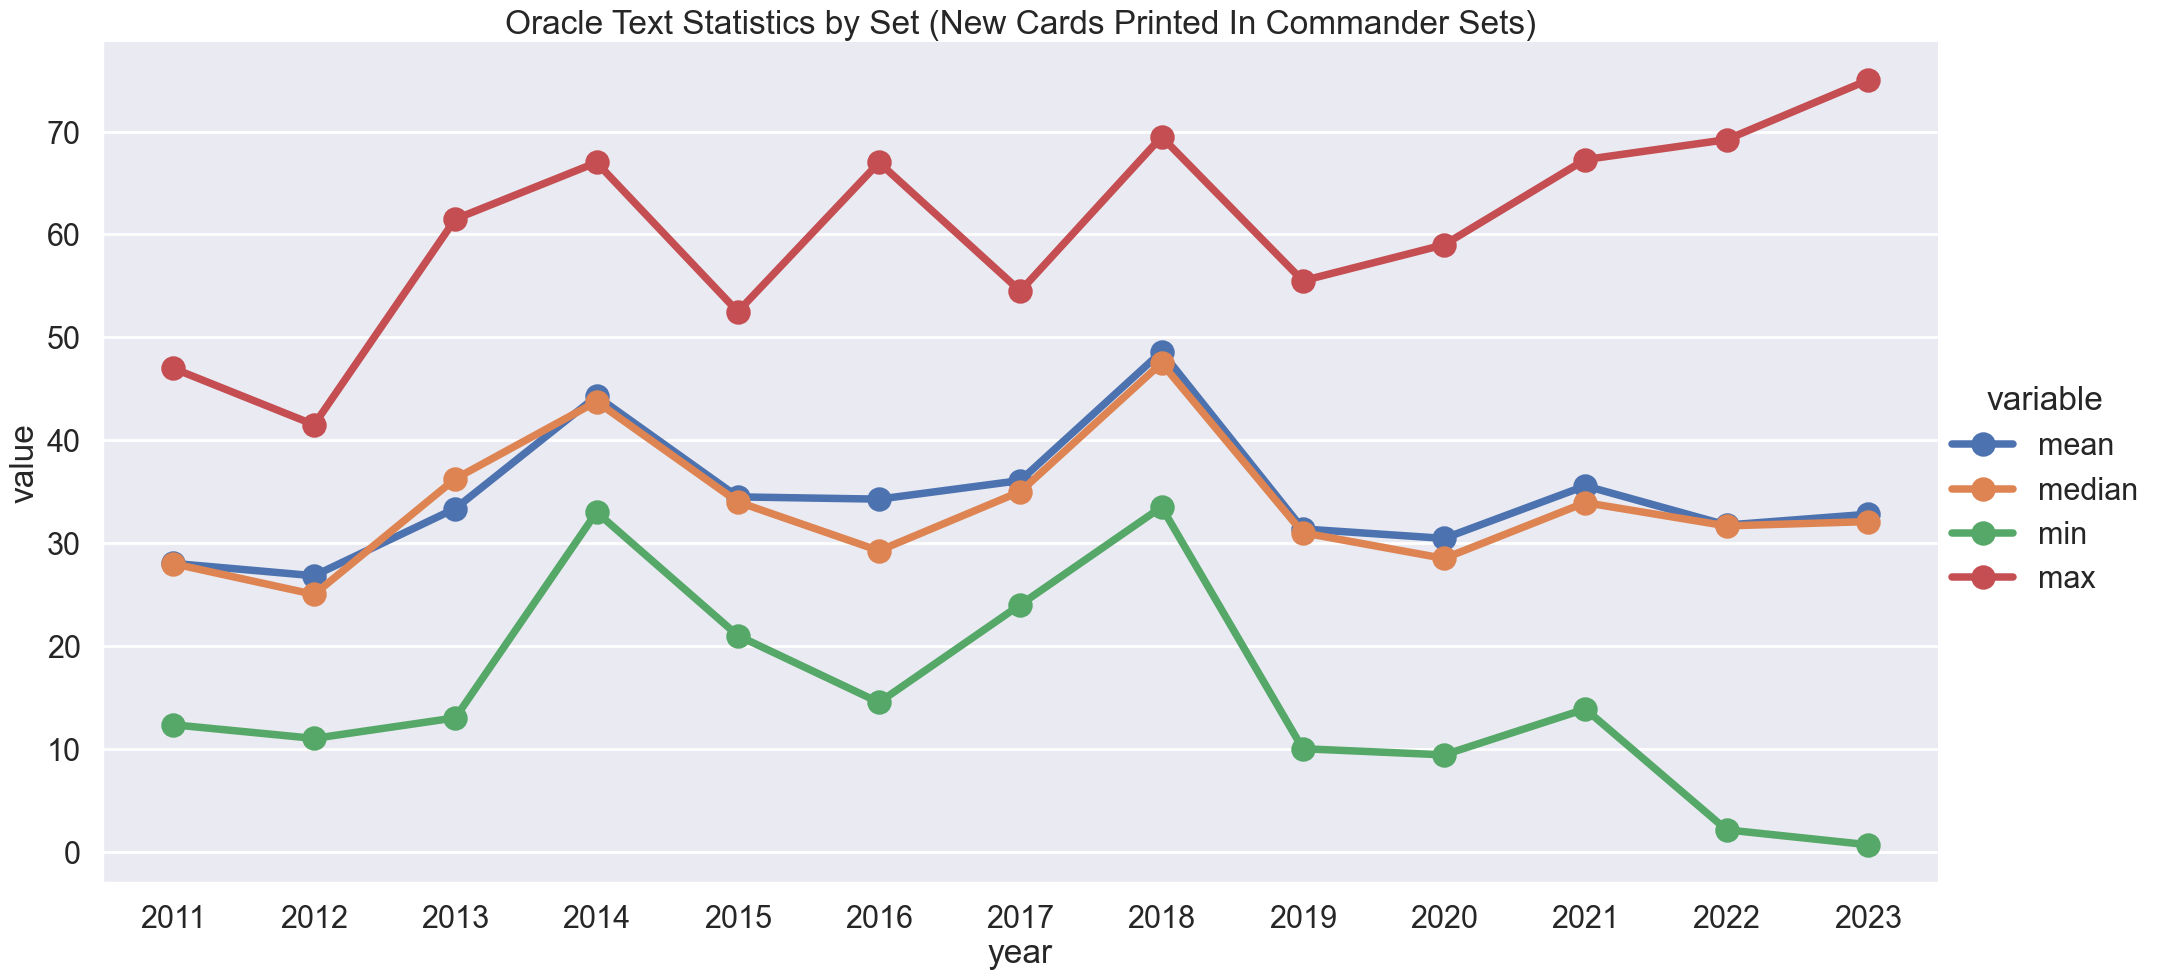

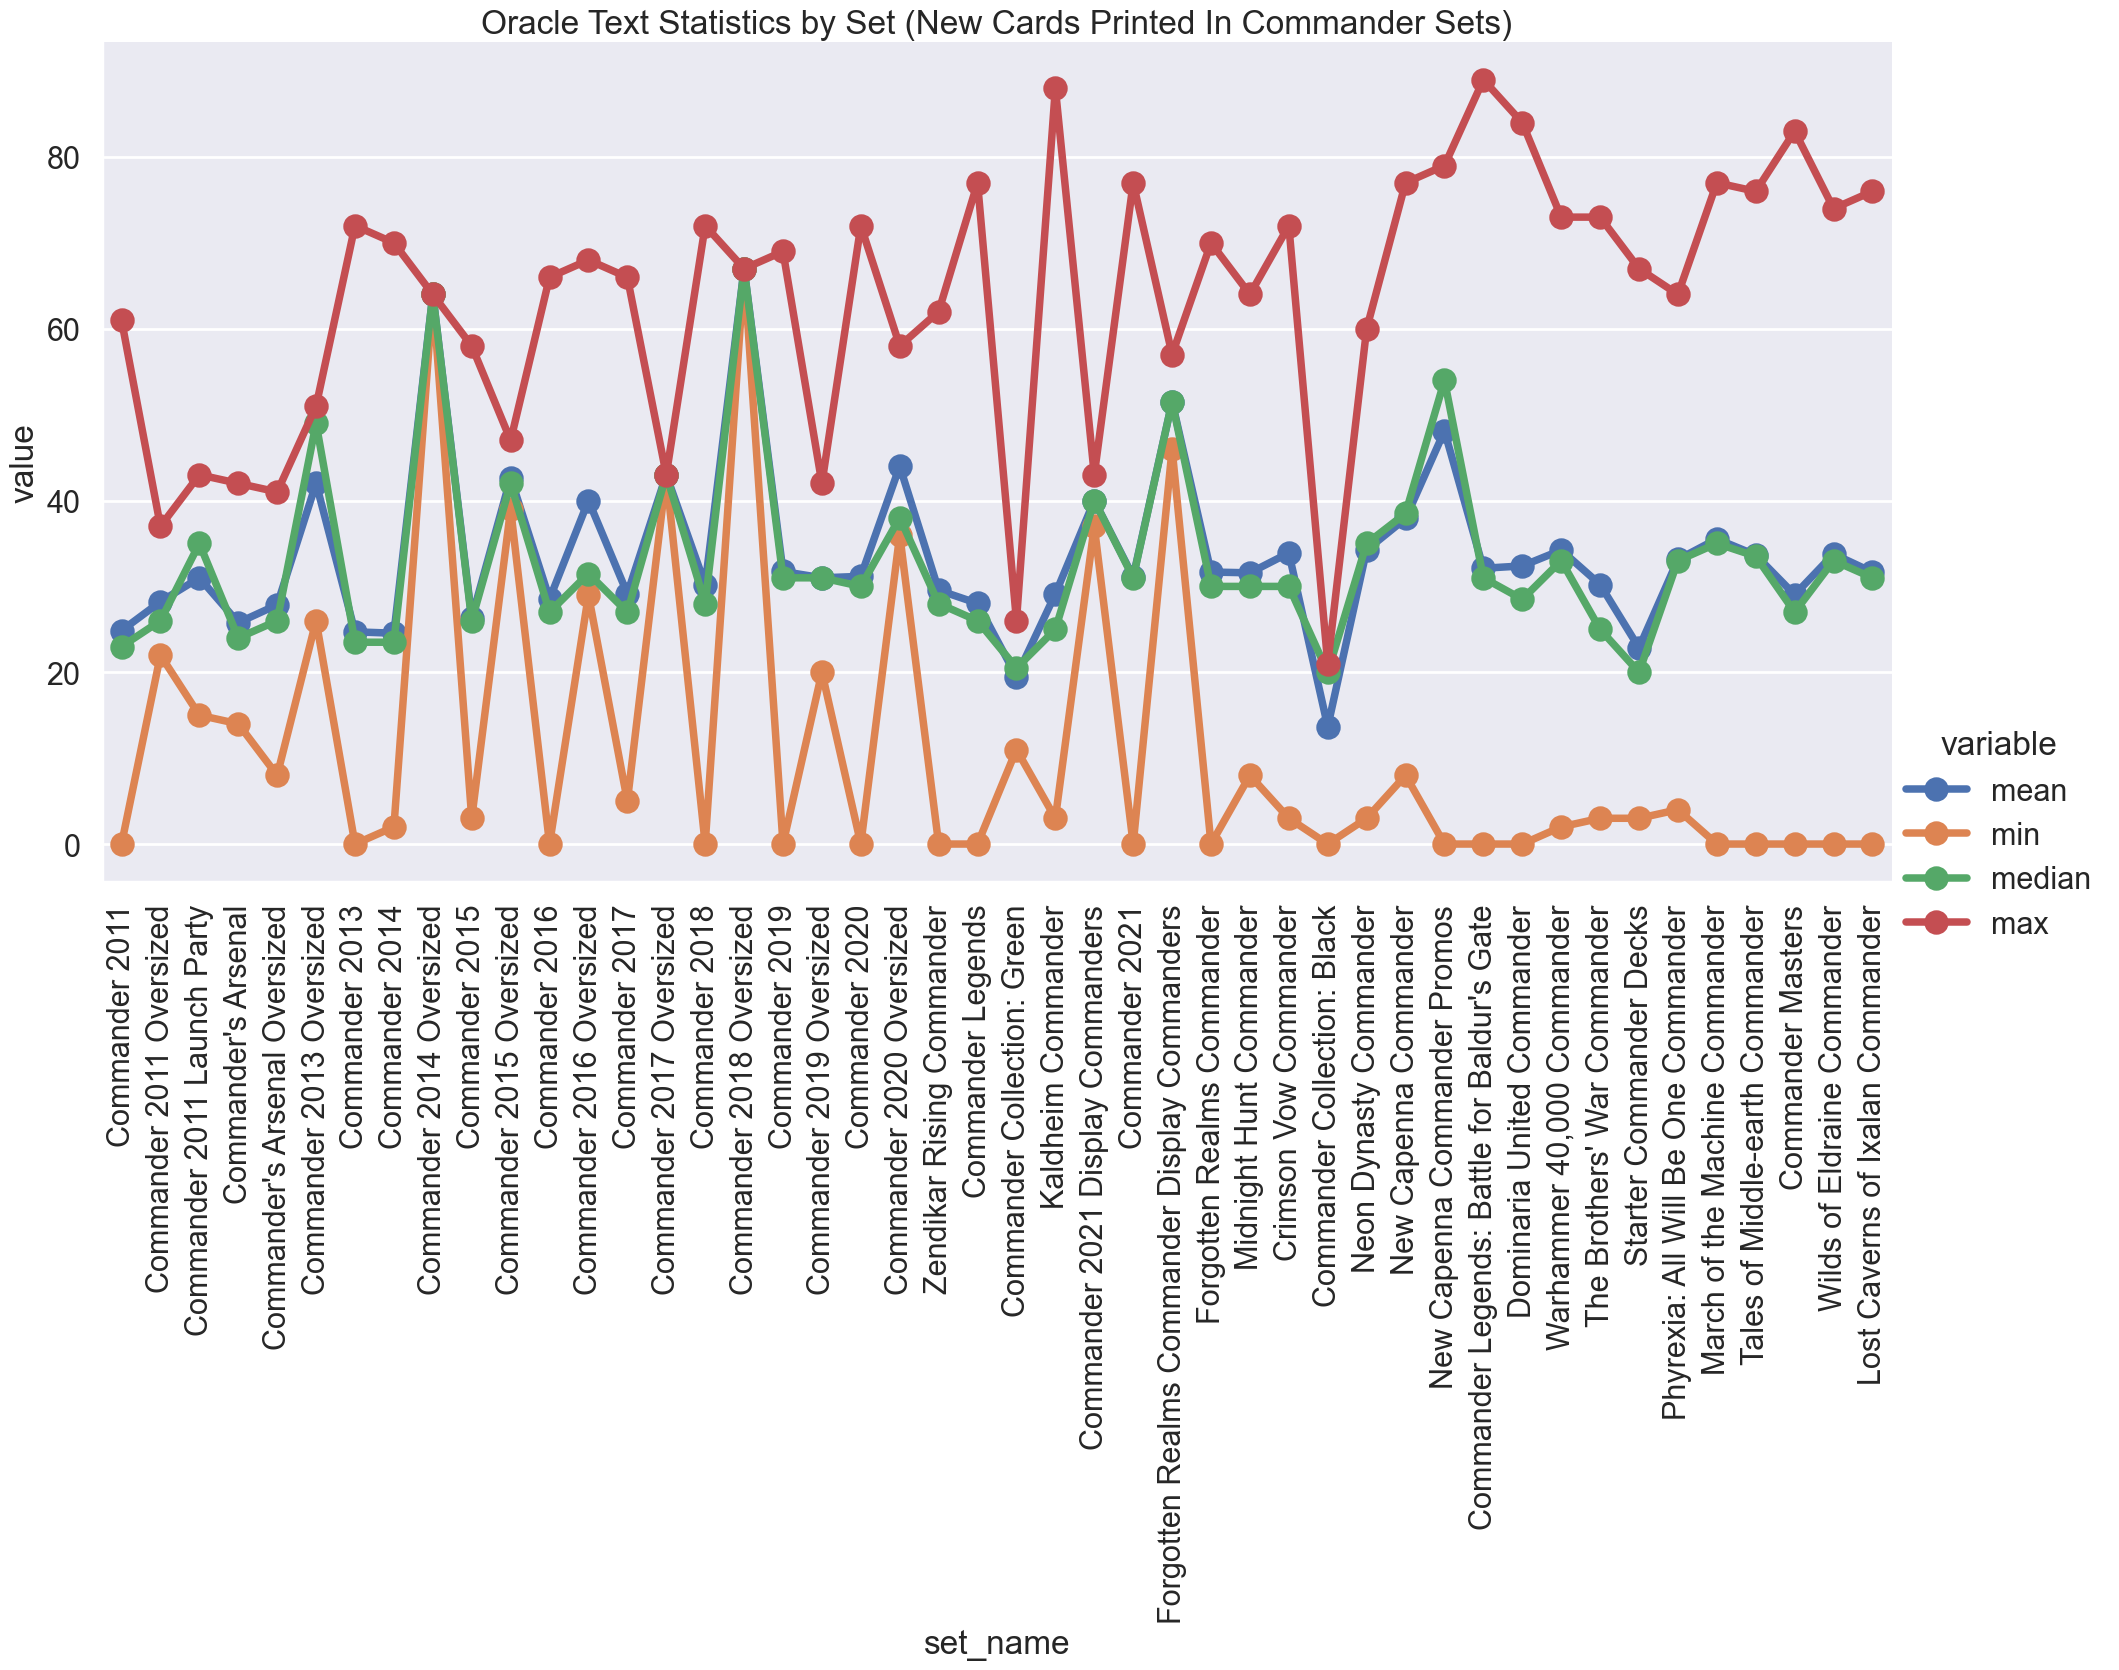

In [61]:
unique_commander_df.loc[:, 'released_at'] = pd.to_datetime(unique_commander_df['released_at'])
unique_commander_df.loc[:, 'year'] = unique_commander_df['released_at'].dt.year

# Group the data by 'year' and get the number of cards in each group
cards_per_year = unique_commander_df.groupby('year').size()

# Create a graph showing the number of cards per year
cards_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of New Commander Cards per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cards')
plt.show()

# Count the number of words in each oracle_text
unique_commander_df.loc[:, 'word_count'] = unique_commander_df['oracle_text'].apply(lambda x: len(str(x).split()))

# Group by set and year, and calculate mean, median, min, and max word count
stats = unique_commander_df.groupby(['set_name', 'year'])['word_count'].agg(['mean', 'median', 'min', 'max']).reset_index()

# Reshape the DataFrame for easier plotting
melted_stats = stats.melt(id_vars=['set_name', 'year'], value_vars=['mean', 'median', 'min', 'max'])

# Create a bar plot with 'year' on the x-axis
sns.catplot(data=melted_stats, x='year', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.title('Oracle Text Statistics by Set (New Cards Printed In Commander Sets)')
plt.show()

# Merge 'released_at' back into the 'melted_stats' DataFrame
melted_stats = pd.merge(melted_stats, unique_commander_df[['set_name', 'year', 'released_at']].drop_duplicates(), on=['set_name', 'year'], how='left')

# Sort the DataFrame by 'released_at'
melted_stats_sorted = melted_stats.sort_values(by='released_at')

# Create a bar plot with 'set_name' on the x-axis
sns.catplot(data=melted_stats_sorted, x='set_name', y='value', hue='variable', kind='point', errorbar=None, height=10, aspect=2)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Oracle Text Statistics by Set (New Cards Printed In Commander Sets)')
plt.show()

In [43]:
# Filter rows where 'type_line' contains "token"
df_token = df[df['type_line'].str.contains('token', case=False, na=False)]

# Print the unique 'type_line' values in these rows
print(len(df_token['type_line'].unique()))

59
